In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from luminol.anomaly_detector import AnomalyDetector
from luminol.modules.time_series import TimeSeries
pd.__version__

'0.24.2'

In [25]:
START_PERIOD = '2019-06-01'
FREQUENCY = 'H'
PERIOD_COUNT = 30*24

In [26]:
%matplotlib inline

In [27]:
def get_event_timestamps(event_name):
    events = pd.read_csv(f"mindset_{event_name}.csv")
    return pd.DataFrame(events, columns=['timestamp'])['timestamp'].apply(pd.to_datetime)

def get_time_series(event_name):
    event_timestamps = get_event_timestamps(event_name)
    
    j=0
    time_series=[]
    timestamps = pd.date_range(START_PERIOD, periods=PERIOD_COUNT, freq=FREQUENCY)
    
    for i in range(timestamps.shape[0] - 1):
        start, event_count, j = count_events(event_timestamps, timestamps[i], timestamps[i+1], j)
        time_series += [[start, event_count]]
        
    return time_series

def get_anomalies(times_series):
    value_for_time = {}
    
    for date_value_pair in times_series:
        date = date_value_pair[0]
        value = date_value_pair[1]
        value_for_time[int(date.timestamp())] = value
        
    detector = AnomalyDetector(value_for_time)
    return detector.get_anomalies()

def anomaly_values(time_series, anomalies):
    values = []
    
    for arr in time_series:
        cur_date = arr[0]

        is_anomaly = 0
        for anomaly in anomalies:
            anom_start = pd.to_datetime(anomaly.start_timestamp, unit='s')
            anom_end = pd.to_datetime(anomaly.end_timestamp, unit='s')
            if cur_date >= anom_start and cur_date <= anom_end:
                is_anomaly = anomaly.anomaly_score
                break

        values.append(is_anomaly)
    
    return values

def count_events(event_timestamps, start, end, j):
    last_idx = event_timestamps.shape[0] - 1
    event_count = 0
    cur_idx = j
    
    while event_timestamps[last_idx-cur_idx] < end:
        if event_timestamps[last_idx-cur_idx] >= start:
            event_count += 1
        cur_idx = cur_idx + 1
        
    return start, event_count, cur_idx

def plot_graph(time_series, anomalies, event_name):
    df = pd.DataFrame.from_records(time_series)
    df.columns = ['date', 'value']
    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = df.value.plot()
    ax.title.set_text(event_name)

    anom_vmin = 0
    anom_vmax = 10

    discrete_colors = [(255, 255, 255), (252, 229, 229), (249, 204, 204), (247, 179, 179), (244, 154, 154), (242, 129, 129), (239, 103, 103), (236, 78, 78), (234, 53, 53), (231, 28, 28), (229, 3, 0)]
    discrete_colors = [(r/255., g/255., b/255.) for r, g, b in discrete_colors]         
    colormap = ListedColormap(discrete_colors)

    Z = np.array([anomaly_values(time_series, anomalies)])
    ax.pcolor(Z, cmap=colormap, vmin=anom_vmin, vmax=anom_vmax)

/anaconda3/envs/lazylantern/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (22,26,29,44) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


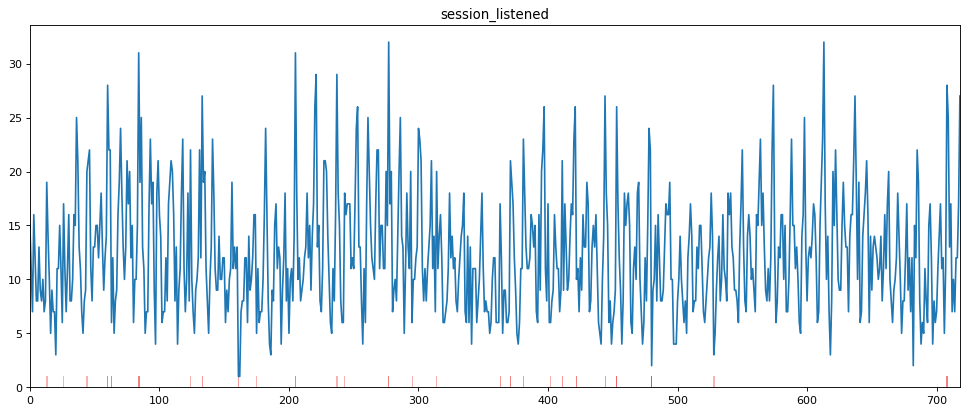

In [28]:
event_name = "session_listened"
time_series = get_time_series(event_name)
anomalies = get_anomalies(time_series)
plot_graph(time_series, anomalies, event_name)